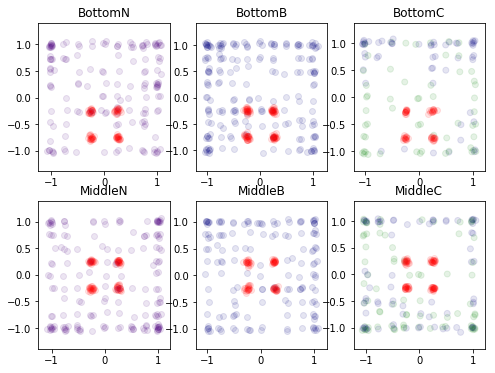

In [66]:
import pymc3 as pm
import numpy as np
import sqlite3, os
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import re

from matplotlib.patches import Ellipse
import theano.tensor as tt
from theano.tensor.nlinalg import det, matrix_inverse
#Gaussian Mixture Model! Now to multivariateness!
execfile('Imports.py')
import Modules.Funcs as funcs
%matplotlib inline

pd.set_option('precision', 2)
#Fetch pooled data


# import raw-ish data
con = sqlite3.connect('../data/experiment.db')
info = pd.read_sql_query("SELECT * from participants", con)
df = pd.read_sql_query("SELECT * from generation", con)
alphas = pd.read_sql_query("SELECT * from alphas", con)
stimuli = pd.read_sql_query("SELECT * from stimuli", con).as_matrix()

con.close()

savedir = './'
gentypeStr = ['N','B','C'] #not alpha, only beta, beta-gamma
gentypeStrDisp = ['A\'','B','C'] #not alpha, only beta, beta-gamma
conditionLabels = ['Bottom','Middle']
gentypeCols = [[.3,0,.5],[0,0,.5],[0,.5,0]]
pooled_alphas = dict()#np.empty((0, 2))
pooled_betas  = dict()#np.empty((0, 2))
ind_alphas = dict()
ind_betas = dict()
cond_all = []

f, ax= plt.subplots(2,3, figsize=(8, 6))
alpha = .1
jittersd = .03
for i, row in info.iterrows():
    pid, condition, gentype = int(row.participant), row.condition, row.gentype
    condNum = conditionLabels.index(condition)
    gentypeStr_p = gentypeStr[gentype]
    #condInd = condNum*3+gentype #condition index
    condName = condition + gentypeStr_p
    palphas = alphas[condition]    
    pbetas = df.stimulus[df.participant == pid]
    if gentype==2:
        pdf = df.loc[df.participant==pid]
        betastr = [gentypeStrDisp[1] if pdf_row.category=='Beta' else gentypeStrDisp[2] for ii,pdf_row in pdf.iterrows() ]
        betacol = [gentypeCols[1] if pdf_row.category=='Beta' else gentypeCols[2] for ii,pdf_row in pdf.iterrows() ]
    else:
        betastr = gentypeStrDisp[gentype]
        betacol = gentypeCols[gentype]
        
    #stack data
    stacka = stimuli[palphas.as_matrix()] 
    stackb = stimuli[pbetas.as_matrix()]
    #Funnel data into appropriate separate conditions
    if not condName in pooled_alphas.keys():
        pooled_alphas[condName] = np.empty((0,2))
        pooled_betas[condName]  = np.empty((0,2))
        ind_alphas[condName] = dict({pid:np.empty((0,2))})
        ind_betas[condName] = dict({pid:np.empty((0,2))})

    else:        
        pooled_alphas[condName] = np.concatenate((pooled_alphas[condName],stacka), axis=0)
        pooled_betas[condName] = np.concatenate((pooled_betas[condName],stackb), axis=0)
        ind_alphas[condName][pid] = stacka
        ind_betas[condName][pid] = stackb


    cond_all += [condName]

    #jitter data for plotting
    stacka_plot = stacka + np.random.normal(0,jittersd,size=stacka.shape)
    stackb_plot = stackb + np.random.normal(0,jittersd,size=stackb.shape)

    currax = ax[condNum][gentype]
    currax.scatter(stacka_plot[:,0],stacka_plot[:,1],color='r',alpha=alpha)
    currax.scatter(stackb_plot[:,0],stackb_plot[:,1],color=betacol,alpha=alpha)
    currax.set_title(condName)
    currax.axis('equal')

#def plot_data(ax,alphas,betas):
    

In [67]:
#Smush the data into a single array
data_all_pooled = dict()
data_all_ind = dict()
cond_all = ['BottomC']
for cn in cond_all:
    data_all_pooled[cn] = dict()
    data_all_pooled[cn]['data'] = np.concatenate((pooled_alphas[cn],pooled_betas[cn]),axis=0)
    
    data_all_ind[cn] = dict()
    data_all_ind[cn]['data'] = dict()
    for pid in ind_alphas[cn].keys():
        data_all_ind[cn]['data'][pid] = np.concatenate((ind_alphas[cn][pid],ind_betas[cn][pid]),axis=0)



# condName = 'BottomN'
# data = np.concatenate((pooled_alphas[condName],pooled_betas[condName]),axis=0)


In [68]:
#Define models
niter = 1000
#traces = []
def mvnll(mu,chol,z,k):    
    def logp_(value):
        if k==0:
            row = pm.MvNormal.dist(mu=mu[k],chol=chol[:,:,k])
            ll = row.logp(value)
        else:
            for ki in range(0,k): #for each group
                ii = (tt.eq(z,ki)).nonzero()
                zi = z[ii]
                row = pm.MvNormal.dist(mu=mu[ki],chol=chol[:,:,ki])
                temp = row.logp(value[ii])   
                if ki==0:
                    ll = temp
                else:
                    ll = tt.concatenate([ll,temp],axis=0)            
        return tt.sum(ll)
    return logp_

for cn in cond_all:
    data = data_all_ind[cn]['data']
    #Cull data
    save = [79,151]
    n_old = len(data)
    for key in data.keys():
        if not key in save:
            data.pop(key,None)
    #         n_old -= 1
    #         if n_old==save:
    #             break     
    ##
    #Add jitter
    jittersd = .05
    for ppt in data.keys():        
        data[ppt] = data[ppt]+np.random.normal(size=(data[ppt].shape))*jittersd

    n_ppt = len(data)
    data_all_ind[cn]['traces'] = []
    gmm_all = [pm.Model() for i in range(3)]
    n = 12
    for mi in range(3): #three models 
        with gmm_all[mi]:
            k = mi+1
            #Prior
            if k>1:    
                #p = pm.Dirichlet('p', a=np.array([1.]*k), testval=np.ones(k)/k)
                p = 1./k * np.ones(k) #fix it such that it's uniform
                z = pm.Categorical('z', p=p, shape=n)

            mus_p = [[pm.MvNormal('mu_%d_%d' % (pid,i),
                                mu=pm.floatX(np.zeros(2)),
                                tau=pm.floatX(0.1 * np.eye(2)),
                                shape=2)
                        for i in range(k)]
                        for pi,pid in enumerate(data.keys())]
#             mus_k = [[pm.MvNormal('mu_%d_%d' % (pid,i),
#                     mu=mus_p[pi],
#                     tau=pm.floatX(0.1 * np.eye(2)),
#                     shape=(2,))
#                     for i in range(k)]
#                     for pi,pid in enumerate(data.keys())]
#           mus = [np.mean(data[pid],axis=0) for pid in data.keys()]
#             packed_L = pm.LKJCholeskyCov('packed_L_%d' % i,n=2,eta=2.,sd_dist=pm.HalfCauchy.dist(.1),shape=(2,3))
#                         #for i in range(k)]
#             L = pm.expand_packed_triangular(2, packed_L[i])
#                  #for i in range(k)]
#             sigma = pm.Deterministic('sigma_%d' % i ,L[i].dot(L[i].T))
#                      #for i in range(k)]
#             tau = pm.Deterministic('tau_%d' % i,matrix_inverse(sigma[i]))
#                    #for i in range(k)]

#             print mus
#             packed_L_p = [pm.LKJCholeskyCov('packed_L_%d' % pid,n=2,eta=2.,sd_dist=pm.HalfCauchy.dist(.1))
#                         for pi,pid in enumerate(data.keys())]

#             mu = pm.MvNormal('mu', mu=np.array([0.,0.]), cov=np.eye(d)*10, shape=(k,d))
            packed_L = [[pm.LKJCholeskyCov('packed_L_%d_%d' % (pid,i),
                                                   n=2,
                                                   eta=2.,
                                                   sd_dist=pm.HalfCauchy.dist(.1))
                        for i in range(k)]
                        for pi,pid in enumerate(data.keys())]
            L = [[pm.expand_packed_triangular(2, packed_L[pi][i])
                for i in range(k)]
                for pi,pid in enumerate(data.keys())]
            #Build stacked version for advanced indexing
            L_stack = [pm.Deterministic('L_stack_%d' % pid,tt.stack(L[pi],axis=2))
                       for pi,pid in enumerate(data.keys())]
            sigma = [[pm.Deterministic('sigma_%d_%d' % (pid,i) ,L[pi][i].dot(L[pi][i].T))
                    for i in range(k)]
                    for pi,pid in enumerate(data.keys())]
            tau = [[pm.Deterministic('tau_%d_%d' % (pid,i),matrix_inverse(sigma[pi][i]))
                    for i in range(k)]
                    for pi,pid in enumerate(data.keys())]

            #Specify the likelihood


            #Y_obs = pm.MvNormal('Y_obs', mu=mu[z], chol=L[0], observed=data)


            if k>1:
#                 mvnl = [[pm.MvNormal.dist(mu=mus_k[pi][i],chol=L[i]) 
#                        for i in range(k)]
#                         for pi in range(n_ppt)]
#                 Y_obs = [pm.Mixture('Y_obs_%d' % pid,w=p, comp_dists=mvnl[pi],observed=data[pid]) 
#                          for pi,pid in enumerate(data.keys())]
                Y_obs = [pm.DensityDist('Y_obs_%d' % pid,mvnll(mus_p[pi],L_stack[pi],z,k), observed=data[pid])
                        for pi,pid in enumerate(data.keys())]
            else: 
                #z = None
                Y_obs = [pm.DensityDist('Y_obs_%d' % pid,mvnll(mus_p[pi],L_stack[pi],_,0), observed=data[pid])
                        for pi,pid in enumerate(data.keys())]
#                 Y_obs = [pm.MvNormal('Y_obs_%d' % pid,mu=mus_k[pi][i],chol=L[i],observed=data[pid])
#                          for pi,pid in enumerate(data.keys())]

            #step = pm.NUTS(vars=[p, mus[0],mus[1],mus[2],
            #                            packed_L[0],packed_L[1],packed_L[2]])
#             step = pm.Metropolis() #this would work too, right? no need to specify vars
#             #Start the sampler!
#             step = pm.NUTS()
#             data_all_ind[cn]['traces'] += [pm.sample(niter, step=step)]

In [69]:
for mi in range(3): #three models 
    print mi
    with gmm_all[mi]:        
        step = pm.NUTS() #this would work too, right? no need to specify vars
            #Start the sampler!
        data_all_ind[cn]['traces'] += [pm.sample(niter, step=step,progressbar=True,chains=1)]

0


Sequential sampling (1 chains in 1 job)
NUTS: [packed_L_151_0, packed_L_79_0, mu_151_0, mu_79_0]
100%|██████████| 1500/1500 [00:08<00:00, 174.94it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


1


Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [packed_L_151_1, packed_L_151_0, packed_L_79_1, packed_L_79_0, mu_151_1, mu_151_0, mu_79_1, mu_79_0]
>BinaryGibbsMetropolis: [z]
100%|██████████| 1500/1500 [00:32<00:00, 46.37it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


2


Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [packed_L_151_2, packed_L_151_1, packed_L_151_0, packed_L_79_2, packed_L_79_1, packed_L_79_0, mu_151_2, mu_151_1, mu_151_0, mu_79_2, mu_79_1, mu_79_0]
>CategoricalGibbsMetropolis: [z]
100%|██████████| 1500/1500 [04:23<00:00,  8.57it/s]
The acceptance probability does not match the target. It is 0.7183526140590486, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


['sigma_151_0', 'sigma_151_1', 'sigma_151_2', 'mu_151_0', 'mu_151_1', 'mu_151_2']
[Y_obs_79, Y_obs_151]


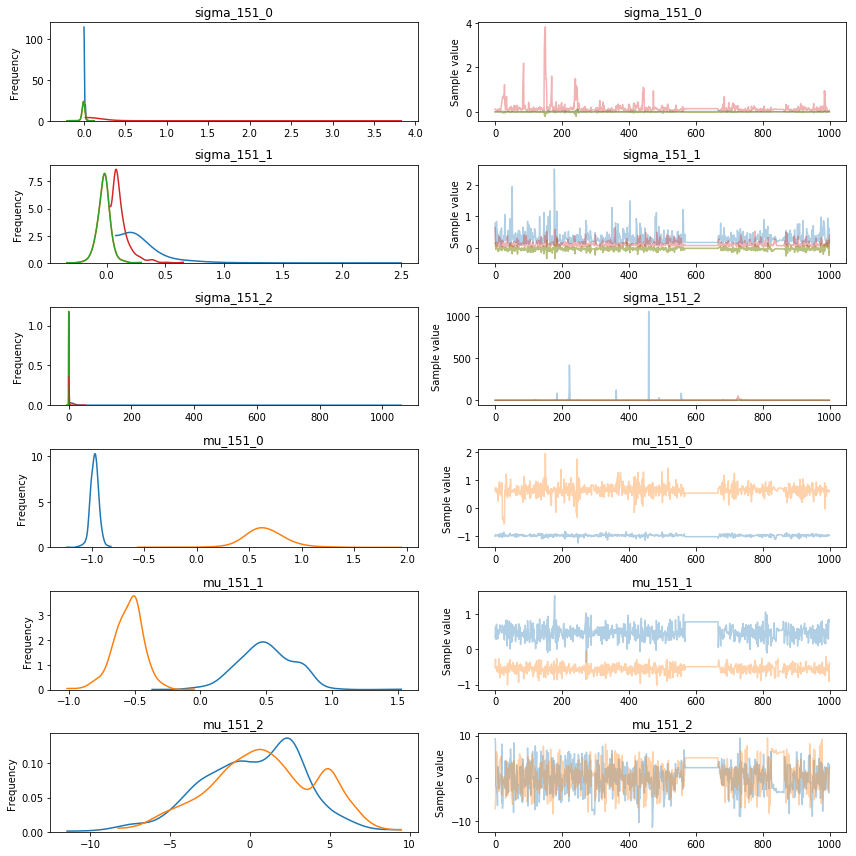

In [71]:
pid = 151
varnames_main = ['sigma_%d'%pid,'mu_%d'%pid]
trace = data_all_ind['BottomC']['traces'][2]
varnames = []
for vi in varnames_main:
    varnames_t = [re.findall('{}.*'.format(vi),string) for string in trace.varnames if len(re.findall('{}.*'.format(vi),string))>0]
    for v in varnames_t:
        varnames += v
print varnames
pm.traceplot(trace[:],varnames=varnames)
print gmm_all[0].observed_RVs
#IS it possible to take out the really high points??

79
[[[ 4.14278396e-03 -6.94313466e-03]
  [-6.94313466e-03  1.12020908e-01]]

 [[ 6.56833488e-01  2.35740209e-02]
  [ 2.35740209e-02  7.30239565e-01]]

 [[ 6.91869121e+00 -5.01621304e-04]
  [-5.01621304e-04  8.85641041e-02]]]
[[ 0.99303249 -0.59787475]
 [-0.04630853  0.07914059]
 [-0.94764911 -0.18293529]]


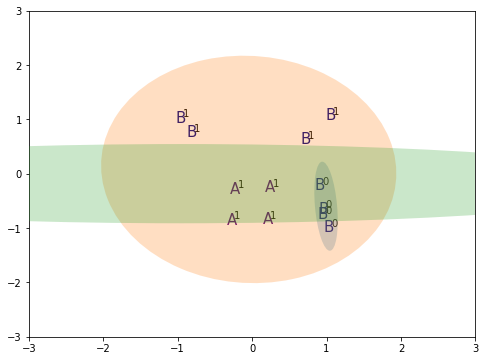

In [80]:
def plot_ellipse(ax,ms,ss):
    colors = sns.color_palette()
    k = ms.shape[0]
    for i in range(k):
        colr = colors[i]
        var, U = np.linalg.eig(ss[i])
#         print U
#         print np.arccos(np.abs(U[0, 0]))
        angle = 180. / np.pi * np.arccos(np.abs(U[0, 0])) #* np.sign(ss[i][1,0])
#         print angle
        e = Ellipse(ms[i,:], 2 * np.sqrt(5.991 * var[0]),
                    2 * np.sqrt(5.991 * var[1]),
                    angle=angle)
        e.set_alpha(0.25)
        e.set_facecolor(colr)
        e.set_zorder(10);
        ax.add_artist(e);

import re

#Convenience line
trace3 = trace
#Data
fig, ax2 = plt.subplots(figsize=(8, 6))
alpha = .5
txt_adj = .1
fontsize = 15
pid = save[0]
print pid
sampiter = -500
#Get list of parm names
# ms_str = [re.findall('mu_\d*_.*',string) for string in trace3.varnames if len(re.findall('mu_\d*_.*',string))>0]
ms_str = [re.findall('mu_%d.*' % pid,string) for string in trace3.varnames if len(re.findall('mu_%d.*' %pid,string))>0]
ss_str = [re.findall('sigma_%d.*' % pid,string) for string in trace3.varnames if len(re.findall('sigma_%d.*'%pid,string))>0]

#Extract posteriors from trace
ms_post = np.array([np.array([trace3[m_str[0]][-sampiter:,0].mean(), trace3[m_str[0]][-sampiter:,1].mean()]) 
           for m_str in ms_str])

ss_post = np.array([np.array([[trace3[s_str[0]][-sampiter:,0,0].mean(), trace3[s_str[0]][-sampiter:,0,1].mean()],
                    [trace3[s_str[0]][-sampiter:,1,0].mean(), trace3[s_str[0]][-sampiter:,1,1].mean()]]) 
           for s_str in ss_str])


# plt.scatter(data[pid][:, 0], data[pid][:, 1], c='g', alpha=alpha)
[plt.text(data[pid][ps, 0]-txt_adj, data[pid][ps, 1]-txt_adj,'A',color=gentypeCols[0],fontsize=fontsize) for ps in range(0,4)]
[plt.text(data[pid][ps, 0]-txt_adj, data[pid][ps, 1]-txt_adj,'B',color=gentypeCols[1],fontsize=fontsize) for ps in range(4,12)]
[plt.text(data[pid][ps, 0], data[pid][ps, 1],int(np.median(trace['z'][:,ps]))) for ps in range(12)]

# ax2.scatter(trace3[ss_str[0][0]][-500:, 0], trace3[ss_str[0][0]][-500:, 1], c="r", s=10,alpha=alpha)
# ax2.scatter(trace3[ss_str[1][0]][-500:, 0], trace3[ss_str[1][0]][-500:, 1], c="b", s=10,alpha=alpha)
# ax2.scatter(trace3[ss_str[2][0]][-500:, 0], trace3[ss_str[2][0]][-500:, 1], c="y", s=10,alpha=alpha)

# plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
# plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)
# plt.scatter(ms[2, 0], ms[2, 1], c='y', s=100)
# ms_post = np.tile(mus[0],(3,1))
plot_ellipse(ax2,ms_post,ss_post)
#plot_ellipse(ax2,np.vstack([ms,ms_post]),np.vstack([ss,ss_post]))
# ax2.axis('equal')
lim = 3
ax2.set_ylim(-lim,lim)
ax2.set_xlim(-lim,lim)
print ss_post
print ms_post
# print ss
#ss_post = [np.array([[ss_post_t[i],covariances[i]],[covariances[i],variances[i]]]) for i in range(k)]

#instead of ellipses, maybe just do posterior checks? but I can't seem to figure out how hmm.

In [78]:
ms_str

[['mu_151_0'], ['mu_151_1'], ['mu_151_2']]

In [17]:
#scatterplot with cluster memberships as color 
#with the ellipses on top
trace['z'].shape

(1000, 12)

NameError: name 'data_all' is not defined

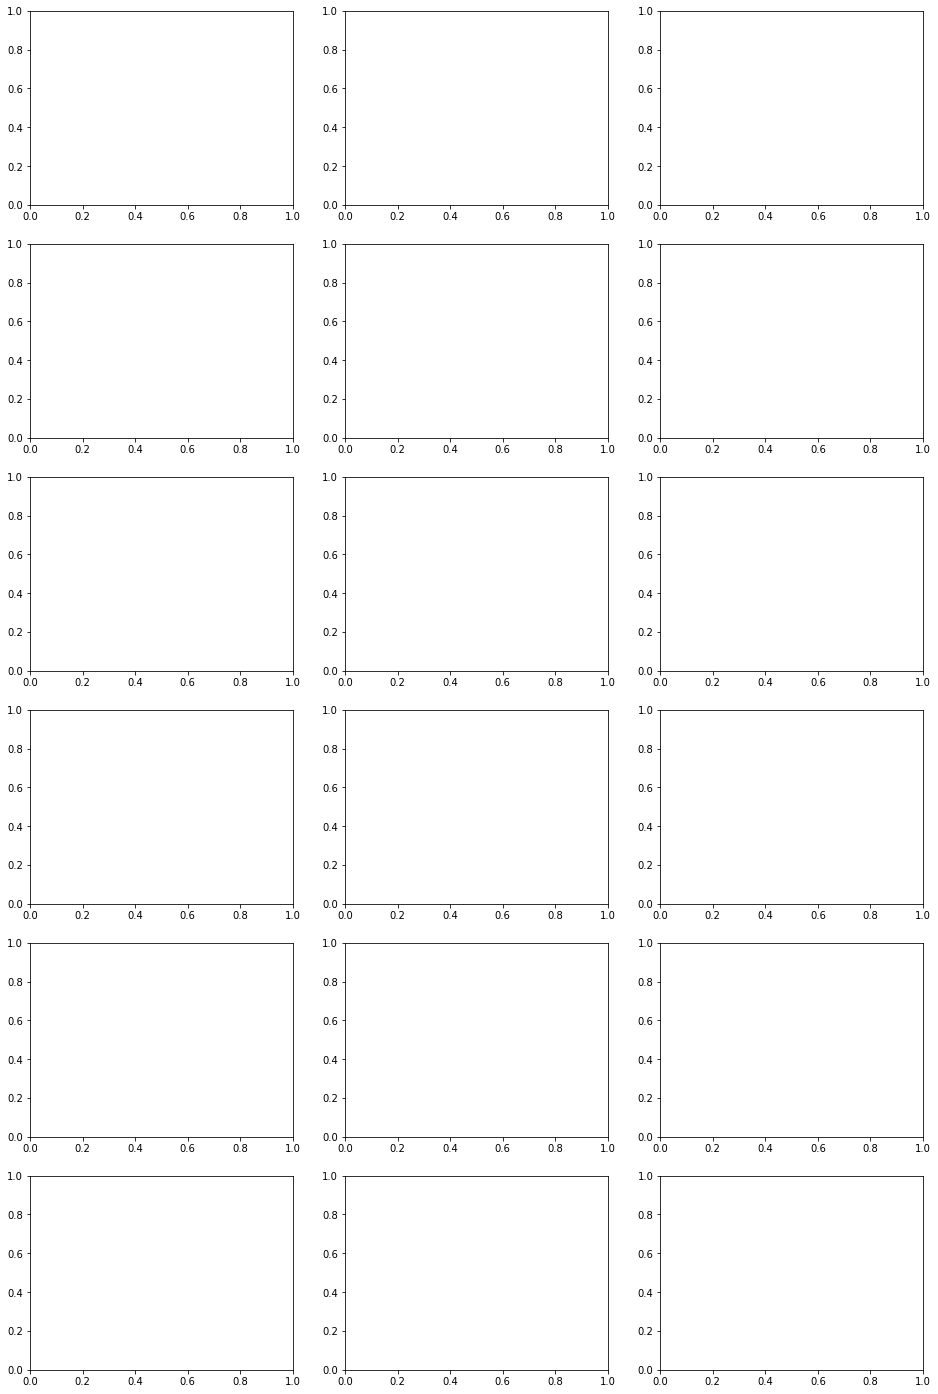

In [132]:
#Let's have a look at the posterior predictives?

def plot_ellipse(ax,ms,ss):
    colors = sns.color_palette()
    k = ms.shape[0]
    for i in range(k):
        colr = colors[i]
        var, U = np.linalg.eig(ss[i])
#         print U
#         print np.arccos(np.abs(U[0, 0]))
        angle = 180. / np.pi * np.arccos(np.abs(U[0, 0])) #* np.sign(ss[i][1,0])
#         print angle
        e = Ellipse(ms[i,:], 2 * np.sqrt(5.991 * var[0]),
                    2 * np.sqrt(5.991 * var[1]),
                    angle=angle)
        e.set_alpha(0.25)
        e.set_facecolor(colr)
        e.set_zorder(10);
        ax.add_artist(e);
        
fig,ax_all = plt.subplots(6,3,figsize=(16,25))
# jitterx = data[:,0] + np.random.normal(0,jittersd,size=data[:,0].shape)
# jittery = data[:,1] + np.random.normal(0,jittersd,size=data[:,0].shape)
# ax.scatter(jitterx,jittery,alpha=.5)

#Posterior predictives
# traces = [trace1,trace2,trace3]
for ci,cn in enumerate(cond_all):
    data = data_all[cn]['data']
    traces = data_all[cn]['traces']
    for ti,trace in enumerate(traces):
        gmm_all[ti].name = str(ti+1) + ' Group'
        jitterx = data[:,0] + np.random.normal(0,jittersd,size=data[:,0].shape)
        jittery = data[:,1] + np.random.normal(0,jittersd,size=data[:,0].shape)
        ax = ax_all[ci,ti]
        ax.scatter(jitterx,jittery,alpha=.1)
        #trace = trace1
        ms_str = [re.findall('mu_.*',string) for string in trace.varnames if len(re.findall('mu_.*',string))>0]
        ss_str = [re.findall('sigma_.*',string) for string in trace.varnames if len(re.findall('sigma_.*',string))>0]
        #Extract posteriors from trace - take about the later half worth of samples?
        ms_post = np.array([np.array([trace[m_str[0]][-int(-niter/2):,0].mean(), trace[m_str[0]][-int(-niter/2):,1].mean()]) 
                   for m_str in ms_str])
        ss_post = np.array([np.array([[trace[s_str[0]][-int(-niter/2):,0,0].mean(), trace[s_str[0]][-int(-niter/2):,0,1].mean()],
                            [trace[s_str[0]][-int(-niter/2):,1,0].mean(), trace[s_str[0]][-int(-niter/2):,1,1].mean()]]) 
                   for s_str in ss_str])

        ax.scatter(trace[ms_str[0][0]][-500:, 0], trace[ms_str[0][0]][-500:, 1], c="r", s=10,alpha=alpha)
        if ti>0:
            ax.scatter(trace[ms_str[1][0]][-500:, 0], trace[ms_str[1][0]][-500:, 1], c="y", s=10,alpha=alpha)
        if ti>1:
            ax.scatter(trace[ms_str[2][0]][-500:, 0], trace[ms_str[2][0]][-500:, 1], c="c", s=10,alpha=alpha)


        plot_ellipse(ax,ms_post,ss_post)
        ax.axis('equal')
        ax.set_ylim(-2,2)
        ax.set_xlim(-2,2)
        ax.set_title(cn + ' ' + str(ti+1) + ' Group')

In [ ]:
# Do some model comparison
for cn in cond_all:
    print cn
    traces = data_all[cn]['traces']
    #ppc = pm.sample_ppc(trace,samples=1,model=gmm) #doesn't seem to work?
    # waic = pm.waic(trace3,model=gmm3)
    compareWAIC = pm.compare({gmm_all[0]:traces[0],gmm_all[1]:traces[1],gmm_all[2]:traces[2]})
    print compareWAIC
    #pm.compareplot(compareWAIC);

    #try LOO
    compareLOO = pm.compare({gmm_all[0]:traces[0],gmm_all[1]:traces[1],gmm_all[2]:traces[2]},ic='LOO')
    print compareLOO
    #pm.compareplot(compareLOO);

In [ ]:
len(info)

In [ ]:
data_all_ind[cn]

In [88]:
data

{79: array([[-0.2558981 , -0.74584022],
        [ 0.2526643 , -0.75764449],
        [-0.25192817, -0.2622708 ],
        [ 0.2509212 , -0.25589755],
        [-1.00619394,  0.99856759],
        [ 1.00114031,  0.99598406],
        [-0.75561802,  0.75247075],
        [ 0.7443943 ,  0.74958332],
        [ 1.00204192, -0.75057504],
        [ 1.00338999, -1.00147201],
        [ 0.99605759, -0.25339486],
        [ 1.00645644, -0.50085529]])}

-0.38425105478389665

In [104]:
traceplot()

TypeError: 'MultiTrace' object is not callable

In [28]:
packed_L[0].tag.test_value

array([1., 0., 1.])

In [32]:
pm.LKJCholeskyCov

pymc3.distributions.multivariate.LKJCholeskyCov